In [1]:
import qsample as qs
import time
import stim
import numpy as np
import matplotlib.pyplot as plt
import time
import re

# Helpers

In [2]:
def dem2matrices(dem, n_detectors):
    txt = dem.split('\n')[1:-1]
    dims = len(txt)
    errors = np.zeros(dims)
    err_locs = np.zeros((dims, n_detectors))

    for i in range(dims):
        errors[i] = re.findall('\d?\.?\d+e?\-?\d+', txt[i])[0]
        for j in re.findall('D\d', txt[i]):
            err_locs[i, int(j[1])]=1

    return errors, err_locs


def error_rate(errors, errloc, sequence):
    dep = len(sequence)
    err = len(errors)
    errors=errors.reshape(1,-1)

    result = np.stack((np.arange(2**err),) * err, axis=1)

    divide = np.stack((2**np.arange(err)[::-1],)*2**err, axis=0) 

    result=result//divide%2      # Creates binary matrix

    result=result[np.all(np.dot(result,errloc)%2==sequence, axis=1)] #find error combination that agrees with sequence
    return np.sum(np.prod(errors*result+(1-errors)*(1-result), axis=1))

In [3]:
class node:
    
    def __init__(self, circuit):
        self.circuit = circuit
        self.zero = None
        self.one = None
        
    def fail_path(self):
        fails= []
        path = []
        if self.one=='1':
            path = ['1']
            fails.append(path)
        else:
            for p in self.one.fail_path():
                p.append('1')
                fails.append(p)
        if self.zero!='0':
            for p in self.zero.fail_path():
                p.append('0')
                fails.append(p)
        return fails
    
    def fail_paths(self):
        p = []
        circs = []
        for j in self.fail_path():
            p.append(j[::-1])
            
        for j in p:
            node = self
            circ = node.circuit
            for i in j[:-1]:
                if i == '1':
                    circ+=node.one.circuit
                    node = node.one
                if i == '0':
                    circ+=node.zero.circuit
                    node = node.zero
            circs.append(circ)
            
        return p, circs

# QSample

In [4]:
teleport = qs.Circuit([{"init": {0, 1, 2}},
                       {"H": {1}},
                       {"CNOT": {(1, 2)}},
                       {"CNOT": {(0, 1)}},
                       {"H": {0}},
                       {"measure": {0, 1}}])

In [5]:
meas = qs.Circuit([{"measure": {2}}], noisy=False)

In [6]:
def lut(syn):
    op = {0: 'I', 1: 'X', 2: 'Z', 3: 'Y'}[syn]
    return qs.Circuit([{op: {2}}], noisy=False)

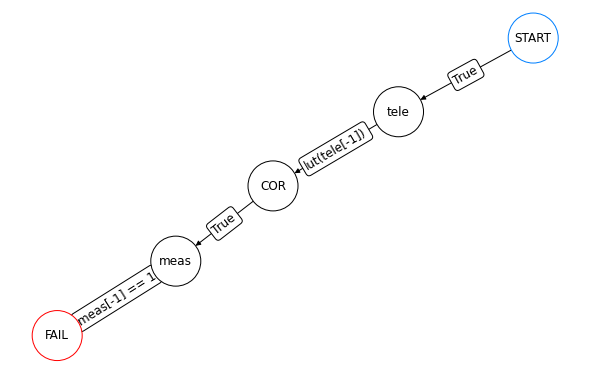

In [7]:
tele_proto = qs.Protocol(check_functions={'lut': lut})
tele_proto.add_nodes_from(['tele', 'meas'], circuits=[teleport, meas])
tele_proto.add_edge('START', 'tele', check='True')
tele_proto.add_edge('tele', 'COR', check='lut(tele[-1])')
tele_proto.add_edge('COR', 'meas', check='True')
tele_proto.add_edge('meas', 'FAIL', check='meas[-1] == 1')

tele_proto.draw(figsize=(8,5))

In [8]:
err_model = qs.noise.E1
q = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.5]
err_params = {'q': q}

In [9]:
begin = time.time()
ss_sam = qs.SubsetSampler(protocol=tele_proto, simulator=qs.StabilizerSimulator,  p_max={'q': 0.1}, err_model=err_model, err_params=err_params, L=3)
ss_sam.run(1000)
end = time.time()
qsample_time = end-begin

p=('1.00e-01',):   0%|          | 0/1000 [00:00<?, ?it/s]

## STIM

In [10]:
xm2 = "X 2\nM 2\nDETECTOR rec[-1] rec[-2]\nTICK\n"
m2 = "M 2\nDETECTOR rec[-1] rec[-2]\nTICK\n"
zm1 = "Z 2\nM 1\nTICK\n"
m1 = "M 1\nTICK\n"
tel = "H 1 \n DEPOLARIZE1({}) 1 \n CNOT 1 2\n DEPOLARIZE2({}) 1 2\n CNOT 0 1\n DEPOLARIZE2({}) 0 1\n H 0\n DEPOLARIZE1({}) 0\n M 0\nTICK\n"

In [11]:
c_m2 = node(m2)
c_m2.zero = '0'
c_m2.one = '1'

c_xm2 = node(xm2)
c_xm2.zero = '0'
c_xm2.one = '1'

c_m1 = node(m1)
c_m1.zero = c_m2
c_m1.one = c_xm2

c_zm1 = node(zm1)
c_zm1.zero = c_m2
c_zm1.one = c_xm2

c_tel = node(tel)
c_tel.zero = c_m1
c_tel.one = c_zm1

In [12]:
err_total = []
begin = time.time()
paths, circuits = c_tel.fail_paths()
paths = [[int(x) for x in y] for y in paths]
for i in q:
    circuit = stim.Circuit(circuits[0].format(i,i,i,i,i))
    dem = circuit.detector_error_model()
    errors, errloc = dem2matrices(repr(dem),1)
    err_total.append(errors[0])
end = time.time()
stim_time = end-begin

# Comparison

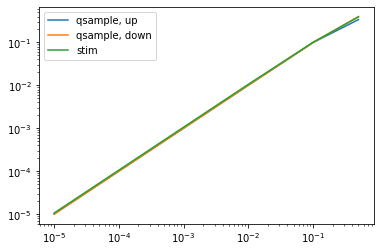

In [13]:
plt.plot(q, ss_sam.stats()[0], label = 'qsample, up')
plt.plot(q, ss_sam.stats()[2], label = 'qsample, down')
plt.plot(q, err_total, label = 'stim')
plt.xscale('log')
plt.yscale('log')
plt.legend()

In [14]:
print("QSample time: {:.3}s".format(qsample_time))
print("STIM time: {:.3}s".format(stim_time))

QSample time: 0.402s
STIM time: 0.00215s
